# データの準備

In [1]:
!curl -O https://www.wiley.com/legacy/wileychi/baltagi/supp/Cigar.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70185    0 70185    0     0   127k      0 --:--:-- --:--:-- --:--:--  127k


In [3]:
import pandas as pd

cigar = pd.read_csv(
    './Cigar.txt',
    header=None, 
    sep='\s',
    names=['state', 'year', 'price', 'pop', 'pop16', 'cpi', 'ndi', 'sales','pimin']
)

skip_state = [3, 9, 10, 22, 21, 23, 31, 33, 48]
cigar = cigar[(~cigar['state'].isin(skip_state)) & (cigar['year'] >= 70)]
cigar['area'] = cigar['state'].apply(lambda x: 'CA' if x==5 else 'Rest of US')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


# DIDの実装

## 集計分析

In [4]:
cigar_did = cigar.copy()
cigar_did['period'] = cigar_did['year'].apply(lambda x: '1_after' if x > 87 else '0_before')
cigar_did['sales*pop16'] = cigar_did['sales'] * cigar_did['pop16']
cigar_did = cigar_did.groupby(['period', 'area'], as_index=False)['pop16', 'sales*pop16'].sum()
cigar_did['sales'] = cigar_did['sales*pop16'] / cigar_did['pop16']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [5]:
cigar_did

,period,area,pop16,sales*pop16,sales
0,0_before,CA,318136.5,3.711305e+07,116.657645
1,0_before,Rest of US,1688312.3,2.141490e+08,126.842072
2,1_after,CA,111776.6,8.620770e+06,77.124997
3,1_after,Rest of US,530748.7,5.673049e+07,106.887669


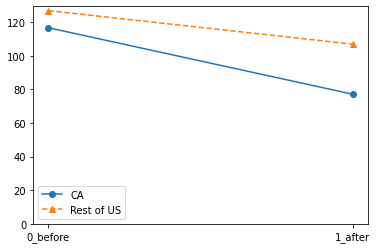

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cigar_did[cigar_did['area'] == 'CA']['period'], cigar_did[cigar_did['area'] == 'CA']['sales'], 'o-', label='CA')
plt.plot(cigar_did[cigar_did['area'] == 'Rest of US']['period'], cigar_did[cigar_did['area'] == 'Rest of US']['sales'], '^--', label='Rest of US')
plt.ylim([0, plt.ylim()[1]])

plt.legend()
plt.show()

## 回帰分析

In [7]:
cigar_did_sum = cigar.copy()
cigar_did_sum['post'] = cigar_did_sum['year'].apply(lambda x: 1 if x > 87 else 0)
cigar_did_sum['ca'] = cigar_did_sum['state'].apply(lambda x: 1 if x == 5 else 0)
cigar_did_sum['year_dummy'] =  'D_' + cigar_did_sum['year'].astype(str)
cigar_did_sum['sales*pop16'] = cigar_did_sum['sales'] * cigar_did_sum['pop16']
cigar_did_sum = cigar_did_sum.groupby(['post', 'year', 'year_dummy', 'ca'], as_index=False)['pop16', 'sales*pop16'].sum()
cigar_did_sum['sales'] = cigar_did_sum['sales*pop16'] / cigar_did_sum['pop16']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [8]:
from statsmodels.formula.api import ols

cigar_did_reg = ols('sales ~ ca + post + ca:post + year_dummy', data=cigar_did_sum).fit()
results = pd.read_html(cigar_did_reg.summary().tables[1].as_html(), header=0)[0]
results[~results['Unnamed: 0'].str.startswith('year')]

,Unnamed: 0,coef,std err,t,P>|t|,[0.025,0.975]
0,Intercept,123.5615,4.519,27.340,0.000,114.163,132.960
23,ca,-9.0898,2.074,-4.384,0.000,-13.402,-4.777
24,post,-13.8569,4.423,-3.133,0.005,-23.054,-4.660
25,ca:post,-20.5435,4.447,-4.619,0.000,-29.792,-11.295


In [9]:
import numpy as np

cigar_did_sumlog = cigar_did_sum.copy()
cigar_did_sumlog['log_sales'] = np.log(cigar_did_sumlog['sales'])

cigar_did_logreg = ols('log_sales ~ ca + post + ca:post + year_dummy', data=cigar_did_sumlog).fit()
results = pd.read_html(cigar_did_logreg.summary().tables[1].as_html(), header=0)[0]
results[~results['Unnamed: 0'].str.startswith('year')]

,Unnamed: 0,coef,std err,t,P>|t|,[0.025,0.975]
0,Intercept,4.8171,0.042,114.363,0.000,4.729,4.905
23,ca,-0.0767,0.019,-3.969,0.001,-0.117,-0.037
24,post,-0.1213,0.041,-2.944,0.008,-0.207,-0.036
25,ca:post,-0.2530,0.041,-6.105,0.000,-0.339,-0.167


## 売り上げデータのプロット

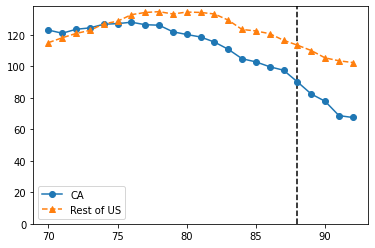

In [10]:
plt.plot(cigar_did_sum[cigar_did_sum['ca'] == 1]['year'], cigar_did_sum[cigar_did_sum['ca'] == 1]['sales'], 'o-', label='CA')
plt.plot(cigar_did_sum[cigar_did_sum['ca'] == 0]['year'], cigar_did_sum[cigar_did_sum['ca'] == 0]['sales'], '^--', label='Rest of US')
plt.ylim([0, plt.ylim()[1]])
plt.vlines(88, 0,  150, linestyles='dashed')

plt.legend()
plt.show()

# CausalImpact

In [63]:
y = cigar[cigar['state'] == 5][['year', 'sales']].set_index('year')
X_sales = pd.pivot_table(cigar[cigar.state != 5][['state', 'sales', 'year']], index='year', columns='state', values='sales').add_prefix('sales_')
pre_period = [cigar[cigar['year'] < 88]['year'].min(), cigar[cigar['year'] < 88]['year'].max()]
post_period = [cigar[cigar['year'] >= 88]['year'].min(), cigar[cigar['year'] >= 88]['year'].max()]
CI_data = pd.concat([y, X_sales], axis=1)

In [13]:
!pip install -q pycausalimpact

In [64]:
from causalimpact import CausalImpact

impact = CausalImpact(CI_data, pre_period, post_period, prior_level_sd=None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


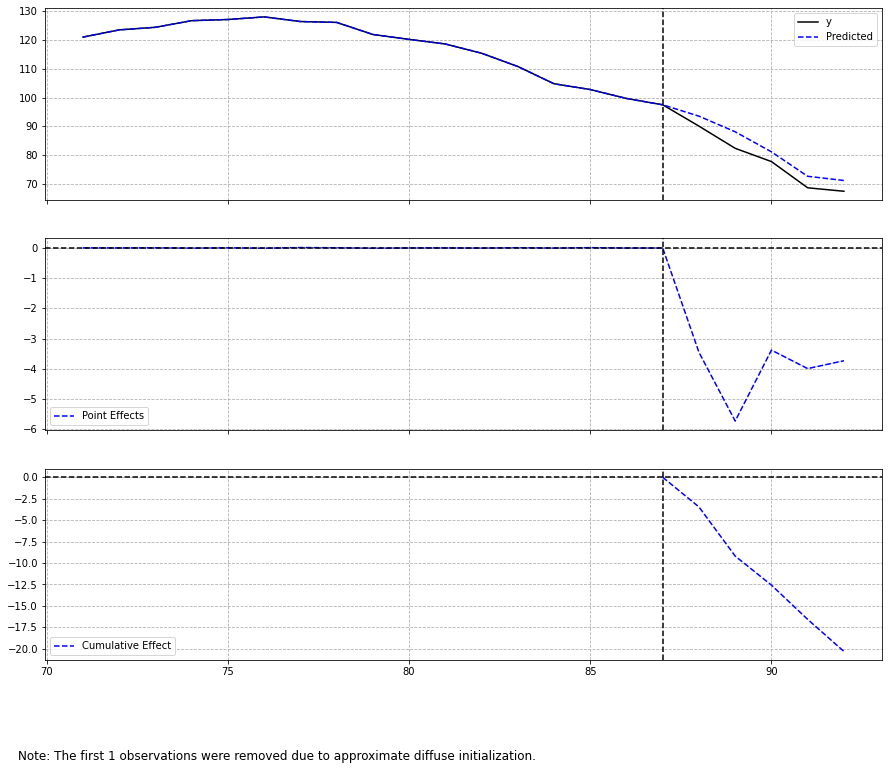

In [65]:
# Rの結果と異なるが、扱っている手法が違う
impact.plot()

In [66]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    77.3               386.5
Prediction (s.d.)         81.36 (0.0)        406.8 (0.02)
95% CI                    [81.35, 81.37]     [406.76, 406.84]

Absolute effect (s.d.)    -4.06 (0.0)        -20.3 (0.02)
95% CI                    [-4.07, -4.05]     [-20.34, -20.26]

Relative effect (s.d.)    -4.99% (0.0%)      -4.99% (0.0%)
95% CI                    [-5.0%, -4.98%]    [-5.0%, -4.98%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [67]:
impact.summary_data

,average,cumulative
actual,77.300000,386.500000
predicted,81.360376,406.801882
predicted_lower,81.352999,406.764995
predicted_upper,81.367705,406.838525
abs_effect,-4.060376,-20.301882
abs_effect_lower,-4.067705,-20.338525
abs_effect_upper,-4.052999,-20.264995
rel_effect,-0.049906,-0.049906
rel_effect_lower,-0.049996,-0.049996
rel_effect_upper,-0.049815,-0.049815
